In [38]:
# load packages
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import os
from datetime import datetime
from sklearn.datasets import make_spd_matrix
from torch.utils.data import random_split, DataLoader

In [43]:
# plot specifications
matplotlib.rcParams['text.usetex'] = True
# font properties for axis
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115)
# font properties for 3d plot axis
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)

In [40]:
def u_analytic(x, y):
    return 16*(1 - x) * x * (1 - y) * y

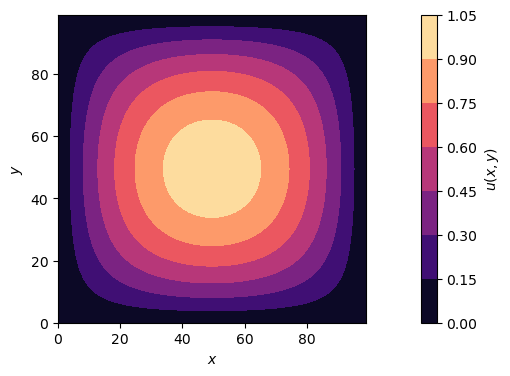

In [42]:
# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, 1, dom_samples)
y = np.linspace(0, 1, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

U = u_analytic(X, Y)

# Mostrar la solución exacta u(x, y)
plt.figure(figsize=(6, 4))  
img = plt.contourf(u_analytic(X, Y), cmap='magma')
plt.colorbar(img, label='$u(x,y)$')   
plt.xlabel(r'$x$')   
plt.ylabel(r'$y$')
plt.axis("image")
plt.grid(False)

N = X.shape[0] * X.shape[1]
XU_num = np.column_stack((X.reshape(N,1), X.reshape(N,1), U.reshape(N,1)))

In [86]:
# Choose 50 random indices without replacement
random_indices = np.random.choice(XU_num.shape[0], size=100, replace=False)

# Select the corresponding rows
XU_sample = XU_num[random_indices]

In [87]:
def integration_points(n_int):
    points = torch.linspace(0, 4, n_int+1)[:-1]
    #points += torch.rand(points.shape) * (1 / n_int) + np.random.rand() * 0.05 # random shift

    # points on square
    epsilon = 0.1 # changeable: set the boundary an espilon away from the Omega boundary
    side = 2 + 2*epsilon
    middle = torch.tensor((0,0)).view(1,2)
    points = torch.remainder(points, 4) # transform points to [0,4]
    v1 = torch.tensor((0, side))[None,]
    v2 = torch.tensor((side, 0))[None,]
    v3 = torch.tensor((0, -side))[None,]
    v4 = torch.tensor((-side, 0))[None,]
    points = points.view(-1,1)
    x_int = (middle - 0.5 * (v1 + v2) + torch.clamp(points,0,1) * v1 + torch.clamp(points-1,0,1) * v2 + torch.clamp(points-2,0,1) * v3 + torch.clamp(points-3,0,1) * v4).requires_grad_(True)

    return x_int

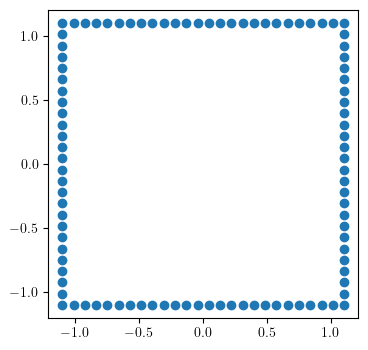

In [88]:
x_int = integration_points(100)
figure, ax = plt.subplots(figsize=(4, 4))
plt.scatter(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy())
plt.axis('equal')
plt.show()

In [89]:
# outer normal directional derivative on boundary of Omega (as a circle)
def outer_normal(x):

    middle = torch.tensor((0,0)).view(1,2)
    max_indices = torch.argmax(torch.abs(x - middle), dim=-1, keepdim=False)
    normals = torch.zeros_like(x)
    sign = torch.sign(x)
    temp_range = torch.arange(x.size(0))
    normals[temp_range, max_indices] = sign[temp_range, max_indices]

    return normals

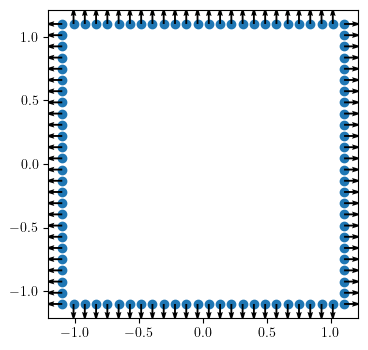

In [90]:
# plot outer normal and x_int
figure, ax = plt.subplots(figsize=(4, 4))
plt.scatter(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy())
plt.quiver(x_int[:, 0].detach().numpy(), x_int[:, 1].detach().numpy(), outer_normal(x_int)[:, 0].detach().numpy(), outer_normal(x_int)[:, 1].detach().numpy())

In [91]:
# fundamental solution of Laplace equation in 2D
def fundamental_solution(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    Phi_0 = -1/(2*torch.pi) * torch.log(distance)

    return Phi_0


# gradient of fundamental solution with respect to y
# grad Phi_0(x,y) = 1/(2π) * (x - y)/||x - y||²
def gradient_fundamental(x, y):

    distance = torch.norm(x - y, p=2, dim=1).view(-1,1)
    grad_Phi_0 = (1/(2*torch.pi)) * ((x - y) / distance**2)
    
    return grad_Phi_0

In [92]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers, n_int):

        super().__init__()
        activation = nn.Tanh
        self.n_int = n_int

        # initialise parameters of sink and source terms
        #random_mag = 0.5*(2*torch.rand(5,1)-1)
        #self.mag = nn.Parameter(sources[:,-1].view(-1,1)+random_mag, requires_grad=True)
        #random_shift = 0.01*(2*torch.rand(5,2)-1)
        #self.loc = nn.Parameter(sources[:,0:2]+random_shift, requires_grad=True)

        # input / start layer
        self.fc_start = nn.Sequential(*[
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ])
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)

    #------------------------------
    # forward pass through network
    def forward(self, x):
        # map x to [-1,1]
        epsilon = 0.1
        x_scaled = 2*(x - torch.tensor([-1-epsilon, -1-epsilon]))/(torch.tensor([1+epsilon, 1+epsilon]) - torch.tensor([-1-epsilon, -1-epsilon])) - 1
        # forward pass
        x_scaled = self.fc_start(x_scaled)  # input layer
        x_scaled = self.fc_hidden(x_scaled) # hidden layer(s)
        u = self.fc_end(x_scaled)    # output layer
        return u

    #------------------------------
    # calculating the potential integrals
    def resample(self):
        # sampling new collocation and integration points
        self.x_int = integration_points(self.n_int)
        # calculating the potential
        self.vmapped_potential_inside = torch.vmap(self.calc_potentials_inside, randomness='same')

    #------------------------------
    # calculating the single and double layer potentials for x being an inside Omega point
    def calc_potentials_inside(self, x):

        epsilon = 0.1
        side = 2 + 2*epsilon

        y = self.x_int
        normal_y = outer_normal(y)
        h_y = self(y) # boundary density, performs forward pass through  neural network with the input y

        # single_layer
        G = fundamental_solution(x, y)
        grad_ones = torch.ones_like(h_y)
        dh_dy = torch.autograd.grad(h_y, y, grad_outputs=grad_ones, create_graph=True)[0]
        dh_dn = torch.sum(dh_dy * normal_y, dim=1).view(-1, 1)
        single_layer = 4*side*torch.mean(G * dh_dn)
        ################
        # double_layer
        dG_dy = gradient_fundamental(x, y)
        dG_dn = torch.sum(dG_dy * normal_y, dim=1).view(-1, 1)
        double_layer = 4*side*torch.mean(dG_dn * h_y)
        return single_layer.squeeze(), double_layer.squeeze()

    #------------------------------
    def predict_u_inside(self, x):
        single_layer, double_layer = self.vmapped_potential_inside(x)
        u_int_data = (single_layer.squeeze() - double_layer.squeeze()).view(-1, 1)
        return u_int_data

In [93]:
def initialise_pibi(lr, n_int):

    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 64 # changeable, use 2**n for efficient memory usage and computation
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pibi = FCNN(N_input, N_output, N_hidden, N_layers, n_int)
    
    # optimizer
    optimiser = torch.optim.Adam(pibi.parameters(), lr=lr)

    # loss function
    mse_loss = torch.nn.MSELoss() # Mean squared error
    
    return pibi, optimiser, mse_loss

In [94]:
# plot loss convergence
def plot_loss(loss_values, n_samples, n_int, data_n, time_now):

    epochs = list(range(1,len(loss_values)+1))

    # Gaussian smoothing
    smoothed_loss_values = gaussian_filter1d(loss_values, 5)

    fig, axs = plt.subplots(1, 2, figsize=(30, 15))
    # loss plot
    axs[0].plot(epochs, loss_values)
    #axs[0].set_yscale('log')
    axs[0].tick_params(axis="both", labelsize=20, pad=5)
    axs[0].tick_params(axis='x', colors='grey')
    axs[0].tick_params(axis='y', colors='grey')
    axs[0].set_xlabel('iterations')
    axs[0].set_ylabel('log(loss)')
    axs[0].set_title('Convergence', size=20)
    legend1 = axs[0].legend(['loss'])
    for text in legend1.get_texts():
        text.set_fontsize(20)

    # smoothed loss plot
    axs[1].plot(epochs, smoothed_loss_values)
    #axs[1].set_yscale('log')
    axs[1].tick_params(axis="both", labelsize=15, pad=5)
    axs[1].tick_params(axis='x', colors='grey')
    axs[1].tick_params(axis='y', colors='grey')
    axs[1].set_xlabel('iterations')
    axs[1].set_ylabel('log(loss)')
    axs[1].set_title('Convergence', size=20)
    legend2 = axs[1].legend(['loss'])
    for text in legend2.get_texts():
        text.set_fontsize(20)

    # Adjust layout
    plt.tight_layout()

    # Save or display the plot
    directory = f"{n_samples}_{time_now}"
    plt.savefig(f'{directory}/{data_n}_{n_int}_convergence.pdf', dpi=500, format='pdf', bbox_inches='tight')
    if show_plots == True:
        plt.show()

In [95]:
def train_pibi(iterations, pibi, optimiser, mse_loss, data, data_n, n_samples, n_int, time_now, show_plots):

    n_samples -= 6

    # store loss values
    loss_values = []
    pibi_mean = 0
    pibi_std = 0

    for epoch in range(iterations):

        # Clear gradients before forward and backward pass for each batch to avoid accumulation of gradients
        optimiser.zero_grad()

        # compute data loss
        pibi.resample()
        u_int_data = pibi.predict_u_inside(data[:,0:2])
        # compute right hand side
        #source_data = torch.zeros_like(u_int_data)
        #for k in range(0,5):
        #    source_data = source_data + pibi.mag[k]*fundamental_solution(data[:,0:2], pibi.loc[k]*torch.ones_like(data[:,0:2]))
        u_int_data = u_int_data #+ source_data
        loss = mse_loss(u_int_data, data[:,-1].view(-1,1))
        loss_values.append(loss.item())

        # backpropagate loss, take optimiser step
        loss.backward()
        optimiser.step()
        '''
        if epoch % 1000 == 0:
            print(epoch, '; loss', loss.item())
        '''
        if epoch == iterations-1:

            # FD solution
            XU_num_tensor = torch.tensor(XU_num, dtype=torch.float64)
            x1 = (XU_num_tensor[:, 0]).reshape((n, n))
            x2 = (XU_num_tensor[:, 1]).reshape((n, n))
            u_num = XU_num_tensor[:,-1].reshape(x1.shape)

            # solve integral for plot points

            u_hom = pibi.predict_u_inside(XU_num_tensor[:, 0:2]) # (N,1)
            #source = torch.zeros_like(u_hom)
            #for k in range(0,5):
            #    source = source + pibi.mag[k]*fundamental_solution(XU_num_tensor[:, 0:2], pibi.loc[k]*torch.ones_like(XU_num_tensor[:, 0:2]))
            u_pibi = u_hom #+ source
            u_pibi = u_pibi.reshape(x1.shape)
            u_pibi = u_pibi.detach() # (101, 101)

            # solve integral for data points and calculate the error
            u_pibi_data = pibi.predict_u_inside(data[:,0:2])
            u_pibi_data = u_pibi_data.detach()
            u_pibi_error_data = torch.abs(u_pibi_data - data[:,-1].view(-1,1))

            # error metrics for plot
            u_error = torch.abs(u_pibi-u_num) # torch.sqrt((u_pibi-u_num)**2)
            u_error_vec = u_error.reshape(n*n,1)
            pibi_mean = torch.mean(u_error_vec)
            pibi_std = torch.std(u_error_vec)
            print('min', torch.min(u_error_vec).item(), 'max', torch.max(u_error_vec).item(), 'mean', pibi_mean.item(), 'std', pibi_std.item())

            # save model
            directory = f"{n_samples}_{time_now}"
            torch.save(pibi.state_dict(), f'{directory}/{data_n}_{n_int}_pibi_model.pt')

            #---------------------------------
            # evaluation plot in 3D
            fig = plt.figure(figsize=(15,15))
            ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
            surf = ax.plot_surface(x1, x2, u_pibi, cmap=cm.jet, linewidth=1, zorder=1)
            ax.scatter(data[:,0], data[:,1], data[:,-1], c='black', marker='o', s=10**1.5, alpha=1, zorder=2)
            # axis ticks
            #ax.tick_params(axis="both", labelsize=40, pad=15)
            ax.tick_params(axis="both", labelsize=60, pad=20)
            major_ticks = [-1,-0.5,0, 0.5,1]
            major_ticks_z = [-2,0,2]
            ax.set_xticks(major_ticks)
            ax.set_yticks(major_ticks)
            ax.set_zticks(major_ticks_z)
            # tick colour
            ax.tick_params(axis='x', colors='grey')
            ax.tick_params(axis='y', colors='grey')
            ax.tick_params(axis='z', colors='grey')
            # labels
            ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
            ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
            ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
            plt.savefig(f'{directory}/{data_n}_{n_int}_pibi_3d.pdf', dpi=500, format='pdf', bbox_inches='tight')
            if show_plots == True:
                plt.show()

            #---------------------------------
            # evaluation plot in 2d
            fig, ax = plt.subplots(figsize=(15, 15))
            img = ax.imshow(u_pibi, cmap='jet', origin='lower',
                            extent=[torch.min(x1).item(), torch.max(x1).item(),
                                    torch.min(x2).item(), torch.max(x2).item()],
                            vmin=-1, vmax=1)
            ax.scatter(data[:,0], data[:,1], c='black', marker='o', s=10**2, alpha=1)
            #for i in range(len(data)):
            #    ax.text(data[i, 0], data[i, 1], f'{data[i, -1]:.1f}', fontsize=30, ha='center', va='bottom')
            # Add contour lines
            contour_levels = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
            contour_lines = ax.contour(x1, x2, u_pibi, levels=contour_levels, colors='k')
            ax.clabel(contour_lines, inline=True, fontsize=35, fmt='%1.2f')
            # axis ticks
            #ax.tick_params(axis="both", labelsize=40, pad=10)
            ax.tick_params(axis="both", labelsize=70, pad=5)
            major_ticks = [-1,-0.5,0, 0.5,1]
            ax.set_xticks(major_ticks)
            ax.set_yticks(major_ticks)
            # tick colour
            ax.tick_params(axis='x', colors='grey')
            ax.tick_params(axis='y', colors='grey')
            # labels
            ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
            ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
            plt.savefig(f'{directory}/{data_n}_{n_int}_pibi_2d.pdf', dpi=500, format='pdf', bbox_inches='tight')
            if show_plots == True:
                plt.show()

            #---------------------------------
            # absolute error plot
            fig, ax = plt.subplots(figsize=(15, 15))
            img = ax.imshow(u_error, cmap='jet', origin='lower',
                            extent=[torch.min(x1).item(), torch.max(x1).item(),
                                    torch.min(x2).item(), torch.max(x2).item()],
                            vmin=0, vmax=2.0)
            ax.scatter(data[:,0], data[:,1], c='black', marker='o', s=10**2, alpha=1)
            #for i in range(len(data)):
            #    ax.text(data[i, 0], data[i, 1], f'{u_pibi_error_data[i, -1]:.1f}', fontsize=16, ha='center', va='bottom')
            # Add contour lines
            contour_levels = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
            contour_lines = ax.contour(x1, x2, u_error, levels=contour_levels, colors='k')
            ax.clabel(contour_lines, inline=True, fontsize=35, fmt='%1.2f')
            # axis ticks
            #ax.tick_params(axis="both", labelsize=40, pad=10)
            ax.tick_params(axis="both", labelsize=70, pad=5)
            major_ticks = [-1,-0.5,0, 0.5,1]
            ax.set_xticks(major_ticks)
            ax.set_yticks(major_ticks)
            # tick colour
            ax.tick_params(axis='x', colors='grey')
            ax.tick_params(axis='y', colors='grey')
            # labels
            ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
            ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
            plt.savefig(f'{directory}/{data_n}_{n_int}_pibi_error.pdf', dpi=500, format='pdf', bbox_inches='tight')
            if show_plots == True:
                plt.show()

            # loss convergence plot
            plot_loss(loss_values, n_samples, n_int, data_n, time_now)

    return pibi, loss.item(), pibi_mean, pibi_std, u_error_vec

In [96]:
show_plots = True
# take samples
n_samples = 100 # number of samples
n_int = 200 # number of integration points

In [97]:
# pibi initialisation
lr = 0.001 # learning rate
pibi, optimiser, mse_loss = initialise_pibi(lr, n_int)

In [98]:
time_now = datetime.now().strftime("%Y%m%d_%H%M")
data = data = torch.tensor(XU_sample, dtype=torch.float64)

In [99]:
# train pibi-net
iterations = 10_001
pibi, end_loss, pibi_mean, pibi_std, u_error = train_pibi(iterations, pibi, optimiser, mse_loss, data, 00, n_samples, n_int, time_now, show_plots)

RuntimeError: shape '[20, 20]' is invalid for input of size 10000